# Model Implementation

M2 맥북의 GPU를 조금 더 잘 지원해주는 텐서플로우와 케라스를 사용해서 구현합니다.

![image-2.png](./img/transformer.png)


## Import Library

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
import numpy as np
import matplotlib.pyplot as plt

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
type(x_train)

numpy.ndarray

In [4]:
a = tf.convert_to_tensor(x_train)

2023-11-28 00:47:03.881201: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2023-11-28 00:47:03.881225: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-28 00:47:03.881233: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-28 00:47:03.881493: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-28 00:47:03.881694: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
tf.transpose(x_train).shape[-1]

60000

## Scaled dot Attention

![image.png](./img/sclaed_dot.png)

$$\text{Attention}(Q, K, V) = \text{softmax}(\frac{QK^T}{\sqrt{d_k}})V$$

querys, keys($d_k$), and values($d_v$) are packed together into a matrix $Q, K$($(seq\_len, d_k)$), $V$($(seq\_len, d_v)$)

In [6]:
class ScaledDotAttention(layers.Layer):
  def __init__(self, masked = False):
    super().__init__() 
    self.masked = masked
  def call(self, query, key, value):
    """
    Args:
        query (): (batch_size, seq_len, d_k)
        key (_type_): (batch_size, seq_len, d_k)
        value (_type_): (batch_size, seq_len, d_v)
    """
    numer = tf.matmul(query, tf.transpose(key, 
                                          perm=[0,2,1] # if not, (d_k, seq_len, batch_size)
                                          )) # (batch_size, seq_len, seq_len)
    scaled = numer / (tf.sqrt(tf.cast(key.shape[-1], dtype=float)) + 1e-7) # prevent devide by zero 
    # TODO: Optional mask operation
    if self.masked == True:
      pass # setting -inf all values of input of the softmax which correspond to illegal connections
    
    weights = tf.nn.softmax(scaled)
    
    attention = tf.matmul(weights, value)   # (batch_size, seq_len, d_v)
    
    return attention   

## MultiHead Attention
![image.png](./img/multi-head.png)
$$
\begin{align*}
\text{MultiHead}(Q, K, V) &= \text{Concat}(\text{head}_1, \cdots, \text{head}_n)W^O\\
                  &\text{where}\ \text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)
\end{align*} 
$$


- $W_i^Q, W_i^K \in \mathbb{R}^{d_{\text{model}}\times d_k}$
- $W_i^V \in \mathbb{R}^{d_{\text{model}}\times d_v}$
- $h = 8$ in paper
- $d_k = d_v = d_{\text{model}}/h = 64$

In [7]:
class MultiHeadAttention(layers.Layer):
  def __init__(self, d_model=512, heads_num=8, masked=False):
    super().__init__()
    self.d_model = d_model
    self.heads_num = heads_num
    self.masked = masked\
    
    # d_k = d_v = d_model / h
    self.W_q = [layers.Dense(self.d_model/self.heads_num) for _ in range(heads_num)]
    self.W_k = [layers.Dense(self.d_model/self.heads_num) for _ in range(heads_num)]
    self.W_v = [layers.Dense(self.d_model/self.heads_num) for _ in range(heads_num)]
    
    self.attention_layers = [ScaledDotAttention(masked) for _ in range(heads_num)]
    
    self.concat = layers.Concatenate()
    
    self.output_layer = layers.Dense(d_model)
    
    
  def call(self, query, key, value):
    """
    Args:
        query (): (batch_size, seq_len, embed_dim)
        key (): (batch_size, seq_len, embed_dim)
        value (): (batch_size, seq_len, embed_dim)
    """
    attentions = []
    
    for i in range(self.heads_num):
      q = self.W_q[i](query)
      k = self.W_k[i](key)
      v = self.W_v[i](value)
      attention = self.attention_layers[i](q, k, v)
      attentions.append(attention)
    
    # Concatenate() layer make run parallel
    concat = self.concat(attentions)
    
    ret = self.output_layer(concat)
    
    return ret

In [8]:
# 입력 데이터 생성
batch_size = 2
seq_len = 5
embed_dim = 3

# 입력 데이터 생성
query_input_multihead = tf.random.normal(shape=(batch_size, seq_len, embed_dim))
key_input_multihead = tf.random.normal(shape=(batch_size, seq_len, embed_dim))
value_input_multihead = tf.random.normal(shape=(batch_size, seq_len, embed_dim))
# Multi-Head Attention 적용
multihead_attention = MultiHeadAttention(d_model=embed_dim, heads_num=2)
attention_output_multihead = multihead_attention(query_input_multihead, key_input_multihead, value_input_multihead)

# 출력 확인
print("\nMulti-Head Attention Output:")
print(attention_output_multihead.numpy().shape)


Multi-Head Attention Output:
(2, 5, 3)


## Add & Norm

In [9]:
class AddAndNorm(layers.Layer):
  def __init__(self):
    super().__init__()
    self.add = layers.Add()
    self.norm = layers.LayerNormalization()
    
  def call(self, layer_output, orgin):
    ret = self.add([layer_output, orgin])
    ret = self.norm(ret)
    return ret

In [10]:
input_shape = (2, 3, 4)
x1 = tf.random.normal(input_shape)
x2 = tf.random.normal(input_shape)
y = AddAndNorm()(x1, x2)
print(y)

tf.Tensor(
[[[-1.6184592   0.73089474 -0.03118897  0.9187534 ]
  [ 0.1152693  -1.1273595  -0.5432351   1.5553255 ]
  [-0.8812485  -1.1065664   1.0976301   0.8901848 ]]

 [[ 0.61737037 -1.506422    1.1346003  -0.24554864]
  [ 0.9927669   0.63744056 -0.01569004 -1.6145175 ]
  [ 0.33727825 -0.70096016 -1.1078955   1.4715774 ]]], shape=(2, 3, 4), dtype=float32)


## Position-wise Feed-Forward Networks

> Another way of describing this is as two convolutions with kernel size = 1.
> Thre dimensionality of input and output is $d_\text{model}$ = 512, and the inner-layer has dimensionality $d_{ff}$ = 2048

In [11]:
class FeedForward(layers.Layer):
  def __init__(self, d_model = 512, d_ff = 2048):
    super().__init__()
    
    self.fc1 = layers.Dense(d_ff, activation = 'relu')
    self.fc2 = layers.Dense(d_model)
  
  def call(self, inputs):
    """
    Args:
        inputs (): (batch_size, seq_len, d_v?)
    """
    ret = self.fc1(inputs)
    ret = self.fc2(ret)
    return ret

In [12]:
input_shape = (2, 3, 512)
x1 = tf.random.normal(input_shape)
FeedForward()(x1)

<tf.Tensor: shape=(2, 3, 512), dtype=float32, numpy=
array([[[-0.00724548,  0.32014138,  0.14682686, ...,  0.18885183,
          0.184701  , -0.34023434],
        [ 0.35366595,  0.01386341,  0.19191137, ...,  0.1726464 ,
         -0.24797958,  0.7704921 ],
        [-0.14745368, -0.71299624, -0.09469962, ..., -0.7836791 ,
         -0.06478266,  0.4695824 ]],

       [[ 0.19906475, -0.6791878 , -0.690568  , ..., -0.14246605,
         -0.4218566 ,  0.35893548],
        [ 0.30987704,  0.31009108, -0.42783344, ...,  0.06303187,
          0.57349575,  0.7912327 ],
        [ 0.22219601,  0.40473306,  0.45560417, ..., -0.10180901,
          0.7539827 ,  0.32992178]]], dtype=float32)>

## Transformer Encoder

In [13]:
class TransformerEncodeLayer(layers.Layer):
  def __init__(self, d_model=512, d_ff=2048,
               heads_num=8, masked=False):
    super().__init__()
    self.d_model = d_model
    self.heads_num = heads_num
    self. masked = masked
    
    # Define layers
    self.dropout1 = layers.Dropout(0.1)
    
    self.mh_att = MultiHeadAttention(d_model=d_model, heads_num=heads_num, masked=masked)
    self.addnorm1 = AddAndNorm()
    self.dropout2 = layers.Dropout(0.1)
    
    self.ff = FeedForward(d_model=d_model, d_ff=d_ff)
    self.addnorm2 = AddAndNorm()    
  
  def call(self, inputs):
    """
    Args:
        query : embedding vector of dimension d_model
        key (): "
        value (): "
    """
    attention = self.mh_att(inputs, inputs, inputs)
    mid_ret = self.addnorm1(attention, inputs)
    
    ff_ret = self.ff(mid_ret)
    ret = self.addnorm2(mid_ret, ff_ret)
    
    return ret

## Positional Encoding

$$
PE_{(pos, 2i)} = sin(pos/10000^{2i/d_{\text{model}}})\\
PE_{(pos, 2i+1)} = cos(pos/10000^{2i/d_{\text{model}}})
$$

https://velog.io/@glad415/Transformer-1.-%ED%8F%AC%EC%A7%80%EC%85%94%EB%84%90-%EC%9D%B8%EC%BD%94%EB%94%A9-by-WikiDocs

In [14]:
def calculate_angle(pos, dim, d_model = 512):
  return pos / (np.power(10000, (2*dim/d_model)))

def positional_encoding(pos, d_model):
  angle_rads = calculate_angle(
    pos = np.arange(pos, dtype = np.float32)[:, np.newaxis],
    dim = np.arange(d_model, dtype = np.float32)[np.newaxis, :],
    d_model=d_model
  )
  
  sines = np.sin(angle_rads[:, 0::2])
  cosines = np.cos(angle_rads[:, 1::2])
  angle_rads = np.zeros(angle_rads.shape)
  angle_rads[:, 0::2] = sines
  angle_rads[:, 1::2] = cosines
  pos_encoding = angle_rads[np.newaxis, ...]
  
  return pos_encoding

In [15]:
# Example usage:
max_position = 50
d_model = 128

pos_encoding = positional_encoding(max_position, d_model)

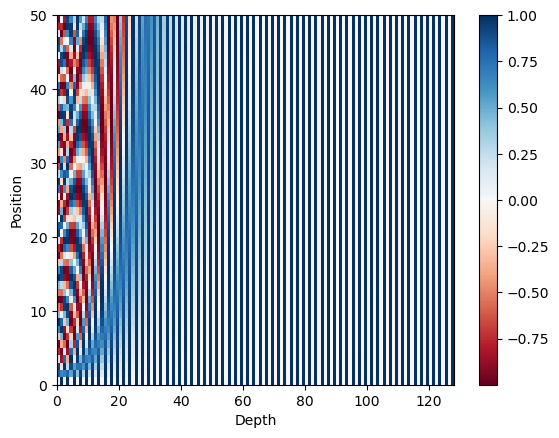

In [16]:
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Embedding and Encoding

In [17]:
class EmbedAndEncode(layers.Layer):
  def __init__(self, seq_len, vocab_size, embed_dim, mask_zero=True):
    super().__init__()
    self.embed_layer = layers.Embedding(vocab_size, embed_dim, mask_zero=mask_zero)
    self.pos_encode =  positional_encoding(seq_len, embed_dim)
  def call(self, input):
    embedded = self.embed_layer(input)
    # print(f'embed_shape : {embedded.shape}')
    # print(f'positional_encoding shape : {self.pos_encode.shape}')
    # print(f'{embedded}')
    ret = embedded + self.pos_encode # broadcast work!
    # print(f'{embedded-self.pos_encode}')
    return ret

In [18]:
# Test
seq_len = 5
vocab_size = 10
embed_dim = 4

# Create an instance of EmbedAndEncode
embed_and_encode = EmbedAndEncode(seq_len, vocab_size, embed_dim)

# Test input sequence (batch_size=2 for demonstration)
test_input = tf.constant([[1, 2, 3, 4, 5], [5, 4, 3, 2, 1]])

# Call the EmbedAndEncode layer
output = embed_and_encode(test_input)

# Display the results
print("Test Input:")
print(test_input)
print("\nEmbedded and Encoded Output:")
print(output)

Test Input:
tf.Tensor(
[[1 2 3 4 5]
 [5 4 3 2 1]], shape=(2, 5), dtype=int32)

Embedded and Encoded Output:
tf.Tensor(
[[[-0.02318497  0.9640815  -0.04015485  0.95770705]
  [ 0.8259397   0.9740322  -0.03652095  1.0494043 ]
  [ 0.9391184   1.008082   -0.01005647  1.0099847 ]
  [ 0.1429663   0.9939411  -0.02407384  1.0498643 ]
  [-0.7097638   1.0250218   0.02413365  1.0057341 ]]

 [[ 0.04703865  1.0258217   0.02373365  1.0057341 ]
  [ 0.84331733  0.9943411  -0.02427384  1.0498643 ]
  [ 0.9391184   1.008082   -0.01005647  1.0099847 ]
  [ 0.12558869  0.9736323  -0.03632095  1.0494043 ]
  [-0.77998745  0.96328163 -0.03975485  0.95770705]]], shape=(2, 5, 4), dtype=float32)


# Simple Text Classification

seq2seq모델이 아니기 때문에, 디코더를 사용하지 않았습니다. 구현도 시간이 없고....

## Device Info

In [19]:
from tensorflow.python.client import device_lib

# 모든 장치의 정보 가져오기
local_device_protos = device_lib.list_local_devices()

# GPU 정보 출력
for device in local_device_protos:
    if device.device_type == "GPU":
        print("GPU Name:", device.name)
        print("GPU Memory:", f"{device.memory_limit / (1024**2):.2f} MB")

GPU Name: /device:GPU:0
GPU Memory: 0.00 MB


2023-11-28 00:47:12.030918: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-28 00:47:12.030938: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Define Model

In [20]:
class ClassifierModel(models.Model):
  def __init__(self, vocab_size, embed_dim=512, seq_len=512, 
               d_model=512, d_ff=2048, heads_num=8, 
               num_transformer_blocks = 3):
    super().__init__()
    self.input_layer = EmbedAndEncode(seq_len=seq_len, vocab_size=vocab_size,embed_dim=embed_dim)
    
    self.encoder = [TransformerEncodeLayer(d_model=d_model,d_ff=d_ff,heads_num=heads_num) for _ in range(num_transformer_blocks)]
    
    self.pooling = layers.GlobalAveragePooling1D()
  
    self.fc = layers.Dense(32, activation = 'relu')
        
    self.ouput_layer = layers.Dense(2, activation = 'softmax')
    
  def call(self, inputs):
    x =  self.input_layer(inputs)

    for encode_layer in self.encoder:
      x = encode_layer(x)
    
    x = self.pooling(x)
    
    x = self.fc(x)
    
    output = self.ouput_layer(x)
    
    return output
  
  def plot(self, input_shape):
    x = layers.Input(input_shape)
    y = self.call(x)
    model = models.Model(inputs = x, outputs = y)
    return tf.keras.utils.plot_model(model, show_shapes=True)

## Data

In [23]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sb
from collections import Counter
from sklearn.model_selection import train_test_split

from konlpy.tag import Komoran

In [24]:
train_data = pd.read_table("./data/ratings_train.txt")
test_data = pd.read_table("./data/ratings_test.txt")

print("train_data =", train_data.shape)
print("test_data =", test_data.shape)

train_data = (150000, 3)
test_data = (50000, 3)


/opt/homebrew/Caskroom/miniconda/base/envs/tensorflow_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/tensorflow_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/tensorflow_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


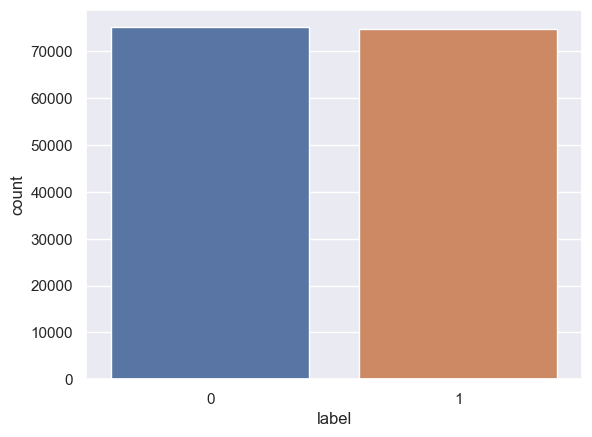

In [25]:
sb.set_theme(style="darkgrid")
graph = sb.countplot(x="label", data = train_data)

In [26]:
tokenizer = Komoran()

def PreProcess(train_data, test_data):
  train_data.drop_duplicates(subset=["document"], inplace = True)
  test_data.drop_duplicates(subset=["document"], inplace = True)
  train_data = train_data.dropna()
  test_data = test_data.dropna()
  print("train shape =", train_data.shape)
  print("test shape =", test_data.shape)
  train_tokenized = [[token+"/"+POS for token, POS in tokenizer.pos(doc_)] for doc_ in train_data['document']]
  test_tokenized = [[token+"/"+POS for token, POS in tokenizer.pos(doc_)] for doc_ in test_data['document']]

  exclusion_tags = ['JKS', 'JKC', 'JKG', 'JKO', 'JKB', 'JKV', 'JKQ', 'JX', 'JC',
                    'SF', 'SP', 'SS', 'SE', 'SO', 'EF', 'EP', 'EC', 'ETN', 'ETM',
                    'XSN', 'XSV', 'XSA']

  f = lambda x: x in exclusion_tags

  X_train = []
  for i in range(len(train_tokenized)):
      temp = []
      for j in range(len(train_tokenized[i])):
          if f(train_tokenized[i][j].split('/')[1]) is False:
              temp.append(train_tokenized[i][j].split('/')[0])
      X_train.append(temp)

  X_test = []
  for i in range(len(test_tokenized)):
      temp = []
      for j in range(len(test_tokenized[i])):
          if f(test_tokenized[i][j].split('/')[1]) is False:
              temp.append(test_tokenized[i][j].split('/')[0])
      X_test.append(temp)

  words = np.concatenate(X_train).tolist()
  counter = Counter(words)
  counter = counter.most_common(30000-4)
  vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
  word_to_index = {word:index for index, word in enumerate(vocab)}

  def wordlist_to_indexlist(wordlist):
      return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

  X_train = list(map(wordlist_to_indexlist, X_train))
  X_test = list(map(wordlist_to_indexlist, X_test))

  return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [27]:
X_train, y_train, X_test, y_test, word_to_index = PreProcess(train_data, test_data)
index_to_word = {index:word for word, index in word_to_index.items()}

train shape = (146182, 3)
test shape = (49157, 3)


In [28]:
all_data = list(X_train)+list(X_test)

num_tokens = [len(tokens) for tokens in all_data]
num_tokens = np.array(num_tokens)
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print("최대 길이 :", maxlen)

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                       padding='pre',
                                                       value=word_to_index["<PAD>"],
                                                       maxlen=70)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       padding='pre',
                                                       value=word_to_index["<PAD>"],
                                                       maxlen=70)

최대 길이 : 28


In [29]:
X_train.shape, X_test.shape

((146182, 70), (49157, 70))

## HyperParameter

In [47]:
seq_len = X_train.shape[-1]
embed_dim=32
d_model=32
d_ff=32
heads_num=2
num_transformer_blocks = 1

learning_rate = 1e-3

## Running

In [49]:
model = ClassifierModel(vocab_size=vocab_size, embed_dim=embed_dim, seq_len=seq_len, 
                        d_model=d_model, d_ff=d_ff, heads_num=heads_num, 
                        num_transformer_blocks = num_transformer_blocks)
optim = optimizers.legacy.Adam(learning_rate=learning_rate)
model.compile(optimizer=optim, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

class LossHistory(tf.keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.losses = []
    self.accuracies = []
    self.val_losses = []
    self.val_accuracies = []
  def on_batch_end(self, batch, logs={}):
    self.losses.append(logs.get('loss'))
    self.accuracies.append(logs.get('accuracy'))
    self.val_losses.append(logs.get('val_loss'))
    self.val_accuracies.append(logs.get('val_accuracy'))

In [50]:
tf.keras.backend.clear_session()

In [51]:
from tensorflow.keras.callbacks import EarlyStopping

tf.keras.backend.clear_session()
early_stopping = EarlyStopping(patience=2)
custom_hist = LossHistory() 
hist = model.fit(X_train, y_train, epochs=10, batch_size = 128, 
                 validation_data=(X_test, y_test), callbacks=[custom_hist])


Epoch 1/10
1143/1143 [==============================] - 76s 64ms/step - loss: 0.6891 - accuracy: 0.5254 - val_loss: 0.6775 - val_accuracy: 0.5665
Epoch 2/10
1143/1143 [==============================] - 62s 55ms/step - loss: 0.6790 - accuracy: 0.5581 - val_loss: 0.6802 - val_accuracy: 0.5648
Epoch 3/10
1143/1143 [==============================] - 62s 54ms/step - loss: 0.6780 - accuracy: 0.5599 - val_loss: 0.6766 - val_accuracy: 0.5670
Epoch 4/10
1143/1143 [==============================] - 61s 54ms/step - loss: 0.6782 - accuracy: 0.5603 - val_loss: 0.6770 - val_accuracy: 0.5642
Epoch 5/10
1143/1143 [==============================] - 63s 55ms/step - loss: 0.6789 - accuracy: 0.5608 - val_loss: 0.6948 - val_accuracy: 0.5370
Epoch 6/10
1143/1143 [==============================] - 63s 55ms/step - loss: 0.6813 - accuracy: 0.5536 - val_loss: 0.6771 - val_accuracy: 0.5666
Epoch 7/10
1143/1143 [==============================] - 64s 56ms/step - loss: 0.6818 - accuracy: 0.5535 - val_loss: 0.6789 -

# Hyperparam Optimization

In [37]:
import keras_tuner as kt

In [39]:
def build_model(hp):
  embed_dim = hp.Choice('embed_dim', [32, 64, 128, 256, 512])
  d_ff = hp.Choice('d_ff', [32, 64, 128, 256, 512, 1024, 2048])
  heads_num = hp.Choice('heads_num', [2, 4, 8])
  num_transformer_blocks = hp.Choice('num_transformer_blocks', [1, 2, 3])
  learning_rate = hp.Choice('learning_rate', [1e-3, 1e-4])
  
  d_model = embed_dim
  
  model = ClassifierModel(vocab_size=vocab_size, embed_dim=embed_dim, seq_len=seq_len, 
                        d_model=d_model, d_ff=d_ff, heads_num=heads_num, 
                        num_transformer_blocks = num_transformer_blocks)
  optim = optimizers.legacy.Adam(learning_rate=learning_rate)
  model.compile(optimizer=optim, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

In [44]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs = 10,
    project_name = 'movie_review_classifier',
    overwrite=True, directory = 'search')

In [52]:
tuner.search(X_train, y_train, epochs = 10, batch_size = 128, 
             validation_data=(X_test, y_test))

Trial 3 Complete [00h 22m 44s]
val_accuracy: 0.5026954412460327

Best val_accuracy So Far: 0.5684439539909363
Total elapsed time: 00h 29m 05s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
32                |128               |embed_dim
2048              |1024              |d_ff
8                 |2                 |heads_num
1                 |1                 |num_transformer_blocks
0.001             |0.001             |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
1143/1143 [==============================] - 214s 179ms/step - loss: 0.6889 - accuracy: 0.5309 - val_loss: 0.6771 - val_accuracy: 0.5663
Epoch 2/2
 624/1143 [===============>..............] - ETA: 1:43 - loss: 0.6794 - accuracy: 0.5575

In [35]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

def create_model(embed_dim=512, d_ff = 2048, heads_num = 8, num_transformer_blocks = 1,
                 learning_rate = 1e-3):
  seq_len = 70
  d_model=embed_dim

  model = ClassifierModel(vocab_size=vocab_size, embed_dim=embed_dim, seq_len=seq_len, 
                        d_model=d_model, d_ff=d_ff, heads_num=heads_num, 
                        num_transformer_blocks = num_transformer_blocks)
  optim = optimizers.legacy.Adam(learning_rate=learning_rate)
  model.compile(optimizer=optim, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=128, verbose=0)

param_grid = {
  'embed_dim' : [32, 64, 128, 256, 512],
  'd_ff' : [32, 64, 128, 256, 512, 1024, 2048],
  'heads_num': [2, 4, 8],
  'num_transformer_blocks': [1, 2, 3],
  'learning_rate': [1e-3, 1e-4]
}

tuner = RandomizedSearchCV(model, param_grid, n_iter = 20, cv = 3)
random_result = tuner.fit(X_train, y_train)

/var/folders/8k/l_bm1gs94r72gg6w58d8xc2m0000gn/T/ipykernel_82659/3979735123.py:16: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=128, verbose=0)


ValueError: 
All the 60 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniconda/base/envs/tensorflow_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniconda/base/envs/tensorflow_env/lib/python3.11/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Caskroom/miniconda/base/envs/tensorflow_env/lib/python3.11/site-packages/keras/wrappers/scikit_learn.py", line 167, in fit
    losses.is_categorical_crossentropy(self.model.loss)
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: module 'keras.losses' has no attribute 'is_categorical_crossentropy'


In [ ]:
hist.history

{'loss': [0.7623478770256042,
  0.5424875020980835,
  0.48838749527931213,
  0.4465582072734833,
  0.4073052704334259,
  0.36876180768013,
  0.3617266118526459,
  0.36038938164711,
  0.3633369207382202,
  0.3812091648578644,
  0.36653852462768555,
  0.3608231544494629,
  0.3576618432998657,
  0.3560537099838257,
  0.35730230808258057,
  0.35564348101615906,
  0.3554535210132599,
  0.3556021451950073,
  0.3570998013019562,
  0.3558098077774048],
 'accuracy': [0.5271599888801575,
  0.7331200242042542,
  0.7690399885177612,
  0.796720027923584,
  0.8192800283432007,
  0.8418800234794617,
  0.8390799760818481,
  0.8418800234794617,
  0.8422399759292603,
  0.8391600251197815,
  0.8415200114250183,
  0.8431599736213684,
  0.8424000144004822,
  0.8438400030136108,
  0.843999981880188,
  0.8440399765968323,
  0.8443999886512756,
  0.843720018863678,
  0.8430799841880798,
  0.8444399833679199],
 'val_loss': [0.6021260619163513,
  0.49872544407844543,
  0.4758150279521942,
  0.43873515725135803,

(0.3, 1.0)

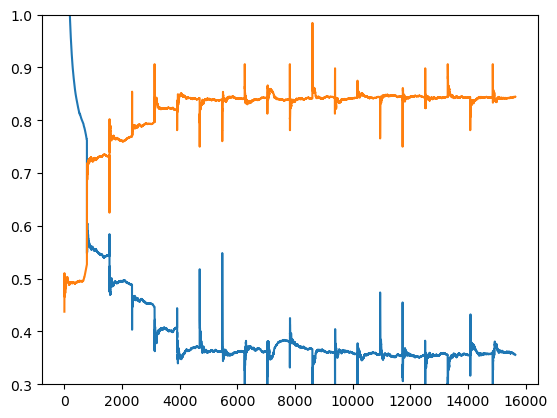

In [ ]:
plt.plot(custom_hist.losses)
plt.plot(custom_hist.accuracies)
plt.ylim((0.3,1))

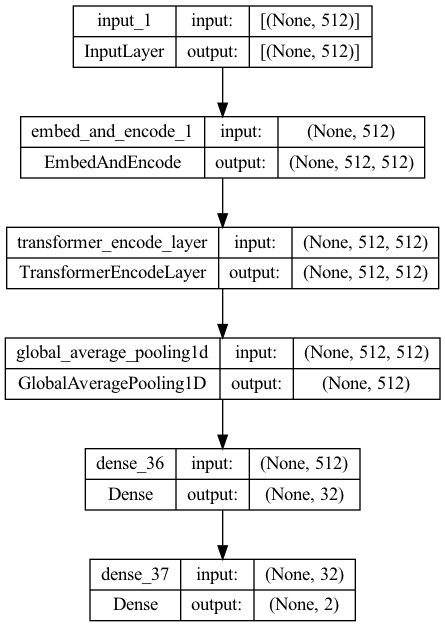

In [ ]:
model.plot((512))